In [1]:
from data_loader import *
from modeling import *
from training import *
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer, get_linear_schedule_with_warmup
import seaborn as sns
import matplotlib.pyplot as plt
from torch import optim
from collections import defaultdict


used data on https://github.com/surge-ai/stock-sentiment

_note_: what I mean by fine tune model is adding dropout layer. will look into further options later

In [2]:
RANDOM_SEED = 42

df = pd.read_csv("data/sentiment.csv")  
map_sentiment = { 'Negative': 0, 'Positive': 1} 
class_names = ['Negative', 'Positive']
df.rename(columns={'Tweet Text': 'news'}, inplace=True)  # change the description name to news as dataloaders.py expects news as column name

df['labels'] = df['Sentiment'].map(map_sentiment)  # map the sentiment to 0 and 1

print(df.columns)
print(df.labels.value_counts())  # check the distribution of the labels


Index(['Stock Ticker', 'news', 'Sentiment', 'Tweet URL', 'labels'], dtype='object')
labels
1    327
0    173
Name: count, dtype: int64


# Bert Model

In [3]:

pre_trained_model = "bert-base-uncased" 
tokenizer = BertTokenizer.from_pretrained(pre_trained_model) # load the tokenizer


/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_5973/3119126063.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

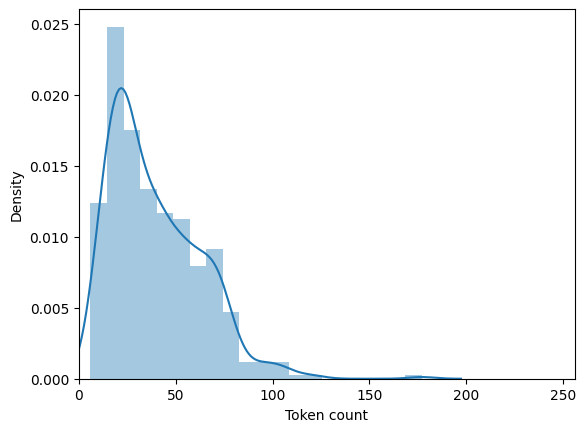

In [5]:
# check the distribution of the token length

token_lens = []
for txt in df["news"]:
    tokens = tokenizer.encode(txt, truncation=True, max_length=512)
    token_lens.append(len(tokens))


sns.distplot(token_lens)

plt.xlim([0,256])

plt.xlabel('Token count')

In [4]:
# split the data to train, validation and test

df_train, df_test = train_test_split(df, test_size = 0.3, random_state = RANDOM_SEED)

df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

In [5]:

max_len = 128 # change accordingly
batch_size = 16 # change accordingly, bu kisimdan emin degilim cunku sonrasinda max len e gore padding yapiyor gibi

train_data_loader = create_data_loader(df_train, tokenizer,  max_len, batch_size, pre_trained_model)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size, pre_trained_model)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size, pre_trained_model)

print(df_train.shape, df_val.shape, df_test.shape)

(350, 5) (75, 5) (75, 5)


In [6]:
# initialize the model with 2 classes and bert-base-uncased
# do_fine_tune = True -> add dropout layer to the model for now
model_fine_tune = SentimentClassifier(2, pre_trained_model, model_name="bert-base-with-dropout" , do_fine_tune = True)
model_fine_tune = model_fine_tune.to(device) # move model to GPU if available

# do_fine_tune = False -> use the model as it is
model_base = SentimentClassifier(2, pre_trained_model,model_name="bert-base", do_fine_tune = False)
model_base = model_base.to(device) # move model to GPU if available


In [7]:
EPOCHS = 5

optimizer = optim.AdamW(model_fine_tune.parameters(), lr= 2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, 
    num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [8]:
EPOCHS = 5

optimizer_base = optim.AdamW(model_base.parameters(), lr= 1e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer_base, 
    num_warmup_steps = 0, 
    num_training_steps=total_steps)




### train fine tuned model

model_fine_tune is trained with 5 epochs, best accuracy on the validation data is saved

In [9]:

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_model(model_fine_tune, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model_fine_tune, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # saves the model with the best accuracy on the validation set on any epoch
    if val_acc>best_accuracy:
        torch.save(model_fine_tune.state_dict(), './saved_models/{}.bin'.format(model_fine_tune.model_name))
        best_accuracy = val_acc

Epoch 1/ 5
---------------
Train loss 0.6373262039639733 accuracy 0.6742857098579407
Val loss 0.5467474818229675 accuracy 0.7599999904632568
Epoch 2/ 5
---------------
Train loss 0.5330364284190264 accuracy 0.7542856931686401
Val loss 0.46891369819641116 accuracy 0.7733333110809326
Epoch 3/ 5
---------------
Train loss 0.38148182291876187 accuracy 0.868571400642395
Val loss 0.3779825001955032 accuracy 0.8666666746139526
Epoch 4/ 5
---------------
Train loss 0.19600999050519682 accuracy 0.9657142758369446
Val loss 0.3386140003800392 accuracy 0.8666666746139526
Epoch 5/ 5
---------------
Train loss 0.07431915190748194 accuracy 0.977142870426178
Val loss 0.32685771882534026 accuracy 0.8799999952316284



### train fine base model without changing the Bert

model_base is trained with 5 epochs, best accuracy on the validation data is saved

In [11]:
history_base = defaultdict(list)
best_accuracy_base = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_model(model_base, train_data_loader, loss_fn, optimizer_base, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model_base, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history_base['train_acc'].append(train_acc)
    history_base['train_loss'].append(train_loss)
    history_base['val_acc'].append(val_acc)
    history_base['val_loss'].append(val_loss)
  
    if val_acc>best_accuracy_base:
        torch.save(model_base.state_dict(), './saved_models/{}.bin'.format(model_base.model_name))
        best_accuracy_base = val_acc

Epoch 1/ 5
---------------
Train loss 0.6529453586448323 accuracy 0.631428599357605
Val loss 0.5800407648086547 accuracy 0.7333333492279053
Epoch 2/ 5
---------------
Train loss 0.5895738886161284 accuracy 0.6800000071525574
Val loss 0.5448025286197662 accuracy 0.746666669845581
Epoch 3/ 5
---------------
Train loss 0.5314376096833836 accuracy 0.7371428608894348
Val loss 0.5096958339214325 accuracy 0.746666669845581
Epoch 4/ 5
---------------
Train loss 0.47866406359455804 accuracy 0.7857142686843872
Val loss 0.47966047525405886 accuracy 0.7733333110809326
Epoch 5/ 5
---------------
Train loss 0.4445045522668145 accuracy 0.8114285469055176
Val loss 0.4685481131076813 accuracy 0.800000011920929


TEST DATA RESULT OF FINE TUNED MODEL (WITH DROPOUT)

In [12]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

              precision    recall  f1-score   support

    Negative       0.83      0.57      0.68        35
    Positive       0.71      0.90      0.79        40

    accuracy                           0.75        75
   macro avg       0.77      0.74      0.73        75
weighted avg       0.77      0.75      0.74        75



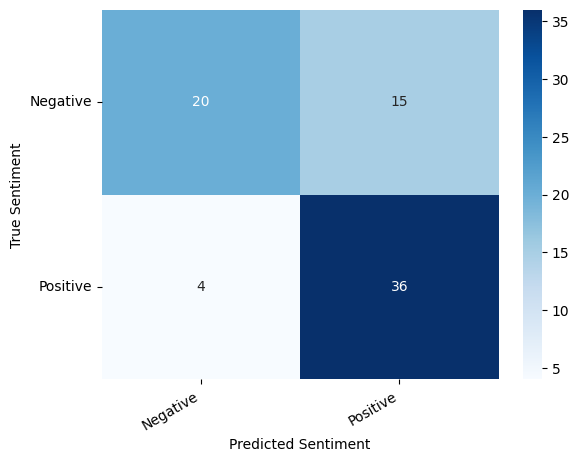

In [21]:

# model_fine_tune = SentimentClassifier(2, pre_train_model="bert-base-uncased", do_fine_tune = True).to(device)
# model_fine_tune.load_state_dict(torch.load("saved_models/best_model_state.bin"))

y_pred, y_pred_probs, y_test = get_predictions(model_fine_tune, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

TEST DATA RESULT WITH BASE

              precision    recall  f1-score   support

    Negative       1.00      0.34      0.51        35
    Positive       0.63      1.00      0.78        40

    accuracy                           0.69        75
   macro avg       0.82      0.67      0.64        75
weighted avg       0.81      0.69      0.65        75



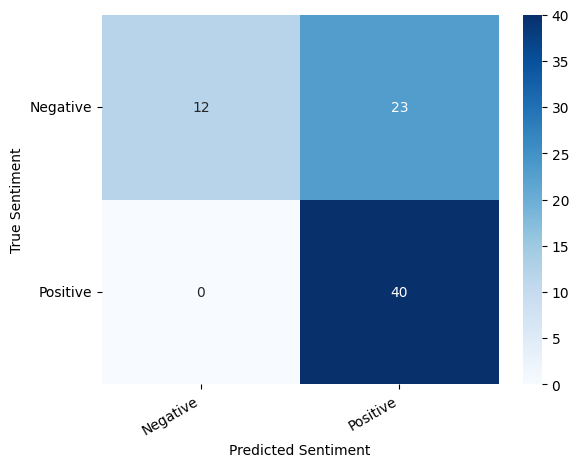

In [17]:
y_pred, y_pred_probs, y_test = get_predictions(model_base, test_data_loader) 
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

# Run model on IEEE data
https://ieee-dataport.org/open-access/stock-market-tweets-data

In [45]:
import pandas as pd
df = pd.read_csv("data/tweets_labelled_ieee.csv", delimiter=';')
df.dropna(inplace=True)
print(df.head())

       id                 created_at  \
0   77522  2020-04-15 01:03:46+00:00   
1  661634  2020-06-25 06:20:06+00:00   
2  413231  2020-06-04 15:41:45+00:00   
3  760262  2020-07-03 19:39:35+00:00   
4  830153  2020-07-09 14:39:14+00:00   

                                                text sentiment  
0  RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...  positive  
1  #SriLanka surcharge on fuel removed!\n⛽📉\nThe ...  negative  
2  Net issuance increases to fund fiscal programs...  positive  
3  RT @bentboolean: How much of Amazon's traffic ...  positive  
4  $AMD Ryzen 4000 desktop CPUs looking ‘great’ a...  positive  


In [46]:
# arrange the column headers, remove neutral sentiment
df= df[df['sentiment'] != "neutral"]
df.reset_index(drop=True, inplace=True)
df.rename(columns={'text': 'news'}, inplace=True) 
df.rename(columns={'sentiment': 'labels'}, inplace=True)

print(df.head())

       id                 created_at  \
0   77522  2020-04-15 01:03:46+00:00   
1  661634  2020-06-25 06:20:06+00:00   
2  413231  2020-06-04 15:41:45+00:00   
3  760262  2020-07-03 19:39:35+00:00   
4  830153  2020-07-09 14:39:14+00:00   

                                                news    labels  
0  RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...  positive  
1  #SriLanka surcharge on fuel removed!\n⛽📉\nThe ...  negative  
2  Net issuance increases to fund fiscal programs...  positive  
3  RT @bentboolean: How much of Amazon's traffic ...  positive  
4  $AMD Ryzen 4000 desktop CPUs looking ‘great’ a...  positive  


In [47]:
map_sentiment = { 'negative': 0, 'positive': 1}
df["labels"] = df["labels"].map(map_sentiment)
df.head()



,id,created_at,news,labels
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",1
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,0
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,1
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,1
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,1


In [60]:
# load the model saved from previous training
model_fine_tune = SentimentClassifier(2, pre_train_model="bert-base-uncased", do_fine_tune = True).to(device)
model_fine_tune.load_state_dict(torch.load("saved_models/best_model_state.bin"))

<All keys matched successfully>

In [52]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = RANDOM_SEED)
print(df_train.head())

         id                 created_at  \
821  467272  2020-06-09 14:58:47+00:00   
181  698256  2020-06-29 20:03:36+00:00   
833  689349  2020-06-28 19:42:26+00:00   
69   756997  2020-07-02 05:30:13+00:00   
131   35371  2020-04-13 19:27:49+00:00   

                                                  news  labels  
821  I got $AAPL at $336 triangle. Up 60%.\n\nI am ...       1  
181     Everything doing great!! #SP500 Great Again!!!       1  
833  RT @leadlagreport: These are the long-term val...       1  
69   $AMZN - Amazon establishes new aerospace cloud...       1  
131  BOOM 💰💰 Come Join US \n$fb $aapl $amzn $nflx $...       1  


In [53]:
print(df.labels.value_counts())

labels
1    528
0    348
Name: count, dtype: int64


In [54]:
max_len  = 512
batch_size = 8
# train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size, include_raw_text=False)
val_data_loader = create_data_loader(df_test,tokenizer, max_len, batch_size )
all_data_loader = create_data_loader(df, tokenizer, max_len, batch_size)

## Fine tuned bert result on IEEE data

In [55]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')



In [32]:
import matplotlib.pyplot as plt

              precision    recall  f1-score   support

    negative       0.69      0.45      0.55       348
    positive       0.71      0.87      0.78       528

    accuracy                           0.70       876
   macro avg       0.70      0.66      0.66       876
weighted avg       0.70      0.70      0.69       876



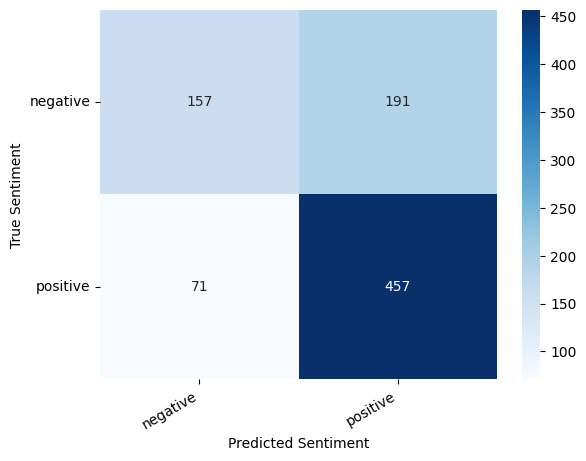

In [61]:
class_names = ['negative', "positive"]
y_pred, y_pred_probs, y_test = get_predictions(model_fine_tune, all_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

## Base model bert result on IEEE data

In [58]:
model_base = SentimentClassifier(2, "bert-base-uncased", do_fine_tune = False).to(device)
model_base.load_state_dict(torch.load("saved_models/bert-base.bin")) # tried to load different model - 

<All keys matched successfully>

              precision    recall  f1-score   support

    negative       0.65      0.43      0.52       348
    positive       0.69      0.85      0.76       528

    accuracy                           0.68       876
   macro avg       0.67      0.64      0.64       876
weighted avg       0.68      0.68      0.67       876



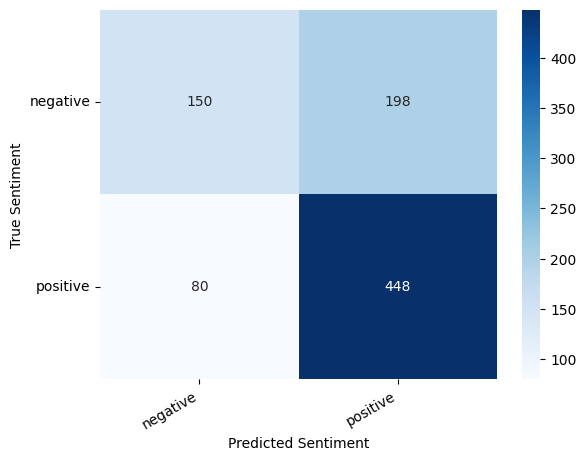

In [59]:
y_pred, y_pred_probs, y_test = get_predictions(model_fine_tune, all_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)